In [198]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from scipy import stats



In [199]:
obesity_dataset = pd.read_csv('Data/obesity.csv')

source: https://www.kaggle.com/datasets/ruchikakumbhar/obesity-prediction/data
### columns:
*    Gender: Gender
*    Age: Age
*    Height : in metres
*    Weight : in kgs
*    family_history : Has a family member suffered or suffers from overweight?
*    FAVC : Do you eat high caloric food frequently?
*    FCVC : Do you usually eat vegetables in your meals?
*    NCP : How many main meals do you have daily?
*    CAEC : Do you eat any food between meals?
*    SMOKE : Do you smoke?
*    CH2O : How much water do you drink daily?
*    SCC : Do you monitor the calories you eat daily?
*    FAF: How often do you have physical activity?
*    TUE : How much time do you use technological devices such as cell phone, videogames, television, computer and others?
*    CALC : How often do you drink alcohol?
*    MTRANS : Which transportation do you usually use?
*    Obesity_level (Target Column) : Obesity level

# Data Analysis


In [200]:
duplicates = obesity_dataset[obesity_dataset.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 24


In [201]:
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

z_scores = pd.DataFrame(stats.zscore(obesity_dataset[numerical_columns]),
                        columns=numerical_columns,
                        index=obesity_dataset.index)
threshold = 3  # Werte mit einem Z-Score > 3 werden als Ausreißer betrachtet
outliers_zscore = obesity_dataset[(z_scores > threshold).any(axis=1)]

print(f"Number of outliers (Z-Score > 3): {outliers_zscore.shape[0]}")

Number of outliers (Z-Score > 3): 25


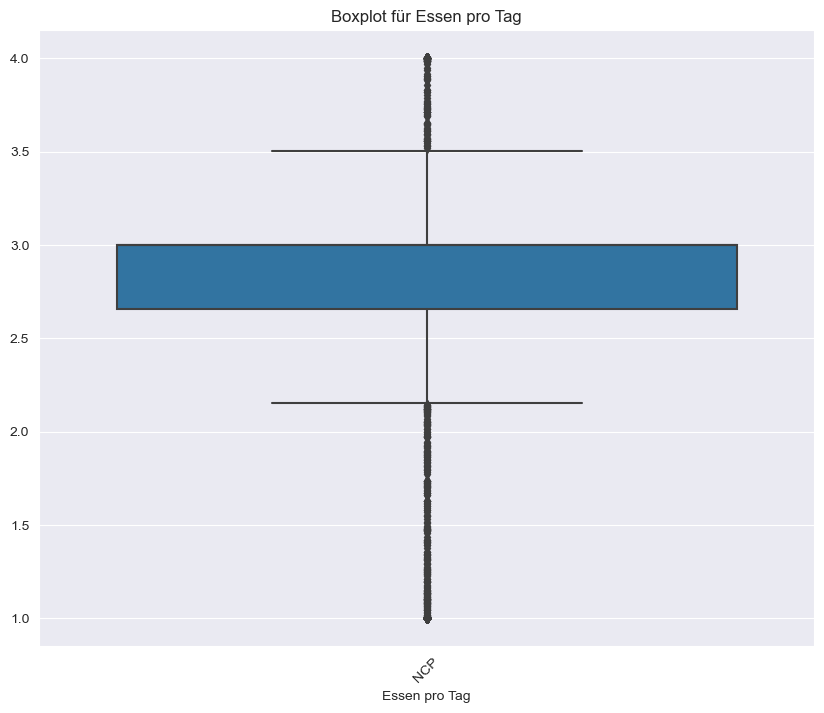

In [202]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=obesity_dataset[['NCP']])
plt.xticks(rotation=45)
plt.xlabel("Essen pro Tag")  # Neue Bezeichnung für die Achse
plt.title("Boxplot für Essen pro Tag")
plt.show()

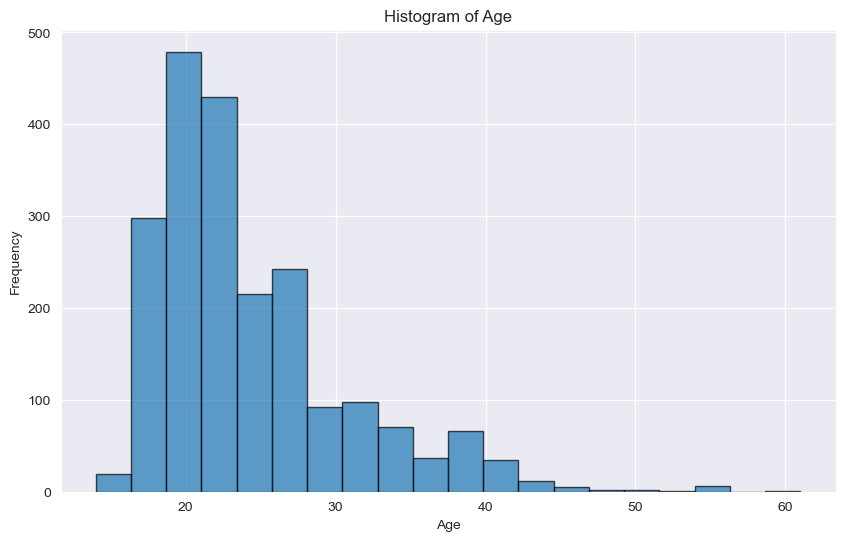

In [203]:
plt.figure(figsize=(10, 6))
plt.hist(obesity_dataset['Age'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

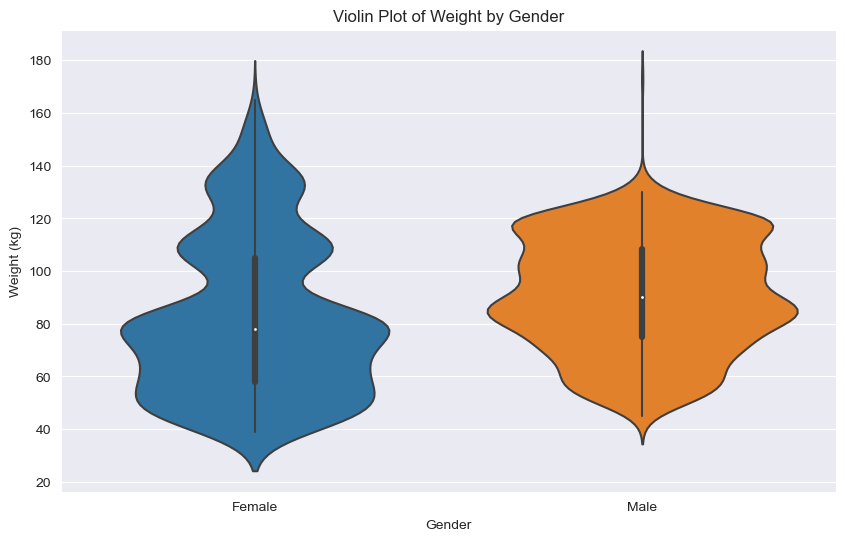

In [204]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Weight', data=obesity_dataset)
plt.title('Violin Plot of Weight by Gender')
plt.xlabel('Gender')
plt.ylabel('Weight (kg)')
plt.show()

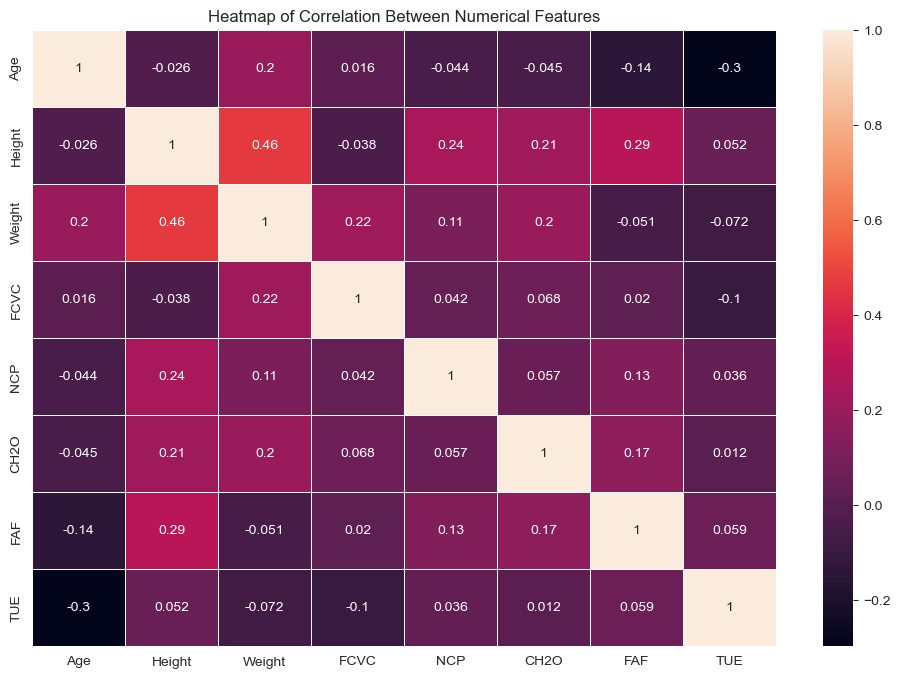

In [205]:
plt.figure(figsize=(12, 8))
correlation_matrix = obesity_dataset.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5)
plt.title('Heatmap of Correlation Between Numerical Features')
plt.show()

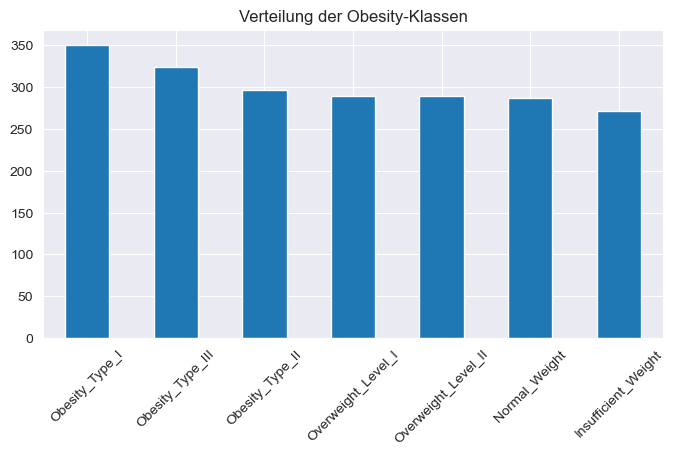

In [206]:
plt.figure(figsize=(8, 4))
obesity_dataset["Obesity"].value_counts().plot(kind="bar")
plt.title("Verteilung der Obesity-Klassen")
plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

In [207]:
obesity_dataset = obesity_dataset.drop_duplicates()

duplicates = obesity_dataset[obesity_dataset.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 0


In [208]:
filtered_dataset = obesity_dataset.loc[~(np.abs(z_scores) > threshold).any(axis=1)]

# Anzahl der entfernten Zeilen
removed_rows = obesity_dataset.shape[0] - filtered_dataset.shape[0]
print(f"Number of removed outlieres: {removed_rows}")
obesity_dataset = filtered_dataset

Number of removed outlieres: 25


In [209]:
obesity_dataset = obesity_dataset.drop(columns=['Height', 'Weight'])

In [210]:
label_enc = LabelEncoder()
obesity_dataset['Obesity'] = label_enc.fit_transform(obesity_dataset['Obesity'])
categorical_features = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
obesity_categorized = pd.get_dummies(obesity_dataset, columns=categorical_features, drop_first=True)

In [211]:
obesity_categorized.head()

,Age,FCVC,NCP,CH2O,FAF,TUE,Obesity,Gender_Male,family_history_yes,FAVC_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,2.0,3.0,2.0,0.0,1.0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,21.0,3.0,3.0,3.0,3.0,0.0,1,0,1,0,...,0,1,1,0,1,0,0,0,1,0
2,23.0,2.0,3.0,2.0,2.0,1.0,1,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,27.0,3.0,3.0,2.0,2.0,0.0,5,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,22.0,2.0,1.0,2.0,0.0,0.0,6,1,0,0,...,0,0,0,0,1,0,0,0,1,0


# Logistic Regression

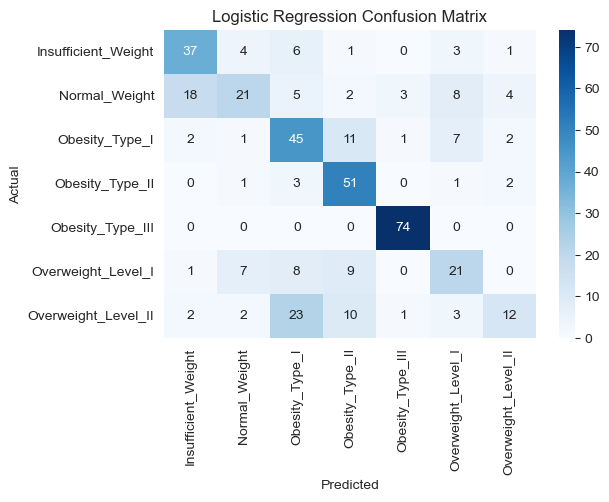

In [212]:
# split data
X = obesity_categorized.drop('Obesity', axis=1)
y = obesity_categorized['Obesity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train logistic regression
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)

# predict
y_pred_lr = log_reg.predict(X_test)

# confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Decision Tree

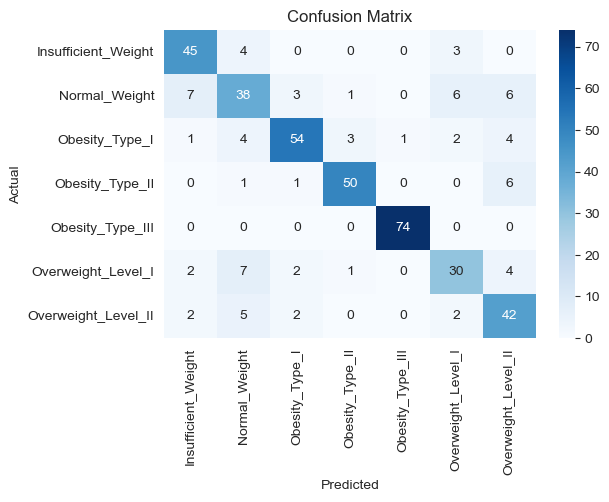

In [213]:
# split data
X = obesity_categorized.drop('Obesity', axis=1)
y = obesity_categorized['Obesity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Predict
y_pred_tree = tree.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Nicht-Lineare Support Vector Machine (Radial Basis Function)

Genauigkeit: 0.7651


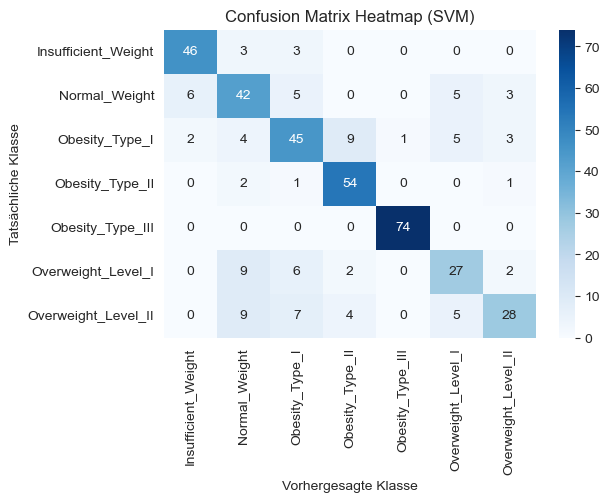

In [214]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report


# Features und Target definieren
X = obesity_categorized.drop(columns=['Obesity'])
y = obesity_categorized['Obesity']

# Skalieren der numerischen Werte
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM-Modell trainieren
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Vorhersage und Evaluierung
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)

# Heatmap der Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.title("Confusion Matrix Heatmap (SVM)")
plt.show()

# Random Forest

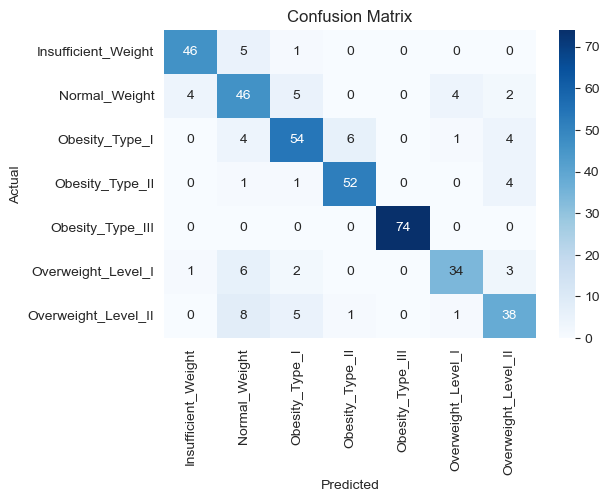

In [215]:
# split data
X = obesity_categorized.drop('Obesity', axis=1)
y = obesity_categorized['Obesity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# predict
y_pred_rf = clf.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# MLP mit Standardeinstellungen von Skit Learn
## Standard Parameter
* hidden_layer_sizes(100,): Eine Schicht mit 100 Neuronen
* activation='relu': ReLU-Aktivierungsfunktion
* solver='adam': Adam-Optimierer für schnelleres Training
* learning_rate='constant': Konstante Lernrate während des Trainings

C:\Users\valen\anaconda3\envs\SpamEmailClassification\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Genauigkeit: 0.7918


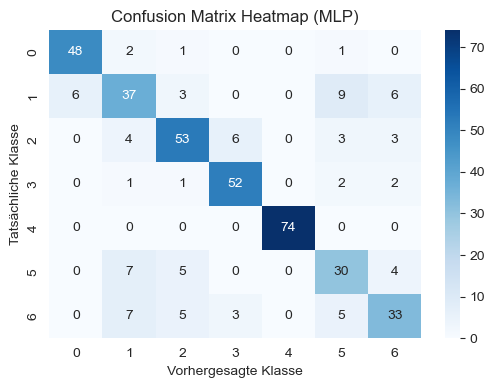

In [216]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Features und Target definieren
X = obesity_categorized.drop(columns=['Obesity'])
y = obesity_categorized['Obesity']

# Skalieren der numerischen Werte
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# MLP-Modell trainieren
mlp_model = MLPClassifier() # Standardwerte
mlp_model.fit(X_train, y_train)

# Vorhersage und Evaluierung
y_pred = mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Heatmap der Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.title("Confusion Matrix Heatmap (MLP)")
plt.show()


# MLP mit Parameter verbessern
* hidden_layer_sizes(128, 64, 32): Drei Schichten mit 128, 64 und 32 Neuronen
* max_iter=1000: Maximale Anzahl von Iterationen, weil das Modell nicht vollständig trainiert wurde

Das Modell kann nun vollständig Trainiert werden. Die Genauigkeit sollte sich verbessern.

Genauigkeit: 0.7821


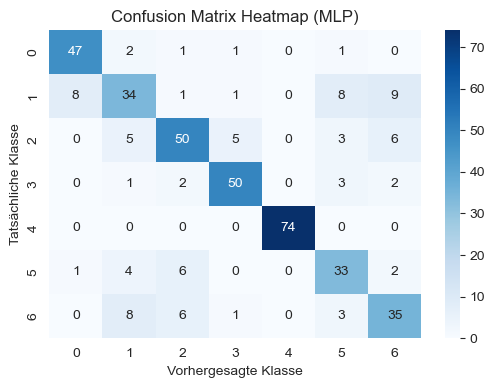

In [217]:
# Features und Target definieren
X = obesity_categorized.drop(columns=['Obesity'])
y = obesity_categorized['Obesity']

# Skalieren der numerischen Werte
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# MLP-Modell trainieren
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Vorhersage und Evaluierung
y_pred = mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Heatmap der Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.title("Confusion Matrix Heatmap (MLP)")
plt.show()

# Clustering (K-Means)

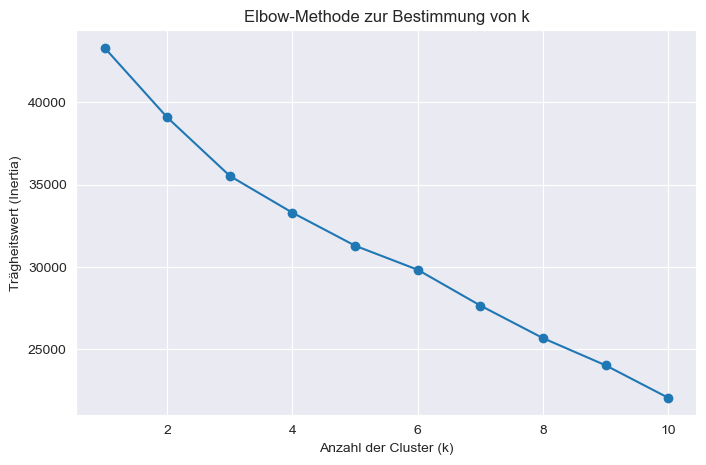

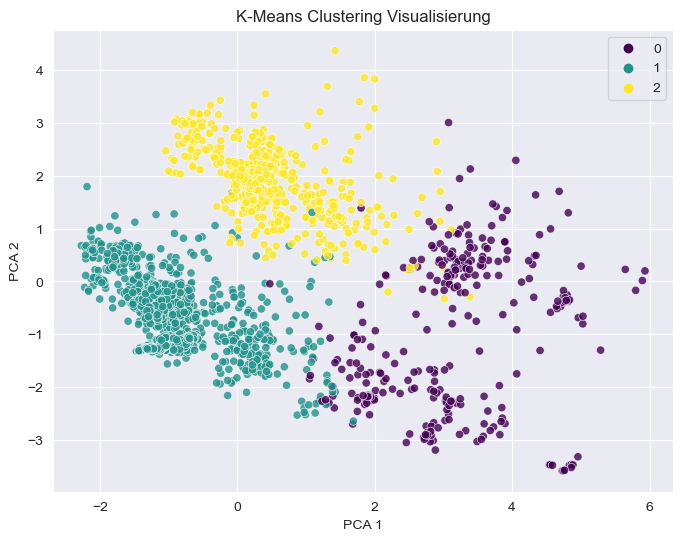

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 🔹 Features definieren (ohne Labels, da K-Means unüberwacht ist)
X = obesity_categorized.drop(columns=['Obesity'])

# 🔹 Skalieren der Daten
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Elbow-Methode zur Bestimmung der optimalen Cluster-Anzahl
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 🔹 Elbow-Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Trägheitswert (Inertia)')
plt.title('Elbow-Methode zur Bestimmung von k')
plt.show()

# 🔹 Beste Anzahl der Cluster (z. B. aus dem Elbow-Plot: k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 🔹 Cluster-Zuordnungen zu den Daten hinzufügen
X_clustered = X.copy()
X_clustered['Cluster'] = clusters

# 🔹 PCA für 2D-Visualisierung der Cluster
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', alpha=0.8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-Means Clustering Visualisierung')
plt.show()
